# Hi There

Welcome to the MNIST Handwritten Digit Recognition project! MNIST, short for "Modified National Institute of Standards and Technology," has been a cornerstone dataset in the field of computer vision since its release in 1999. It serves as the quintessential "hello world" dataset for classification algorithms, providing tens of thousands of handwritten images of digits for researchers and learners to benchmark their techniques.

In this notebook, we will dive on the journey of correctly identifying digits from the MNIST dataset using Convolutional Neural Networks (CNNs). CNNs have revolutionized the field of computer vision and are particularly well-suited for tasks like image recognition.

Whether you're new to machine learning or looking to dive deeper into computer vision, this notebook is designed to provide detailed insights and step-by-step guidance for beginners. We will cover every aspect of building a CNN model for MNIST digit recognition, from data preprocessing and model architecture to training and evaluation.

By the end of this notebook, you will not only have a solid understanding of how CNNs work but also a practical grasp of how to apply them to real-world image recognition tasks.

# **Import Libraries**

In [17]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
from google.colab import drive, files
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import VGG16
from tensorflow.keras import regularizers

# **Data Loading**


In [2]:
# We will use kaggle API for importing the dataset from kaggle to colab
! pip install -q kaggle

# Upload Kaggle API token file (kaggle.json) from local system to the Colab environment.
files.upload()

# Creates a directory named .kaggle in home directory
! mkdir ~/.kaggle

# copies the uploaded kaggle.json file to the .kaggle directory.
! cp kaggle.json ~/.kaggle/

# Sets the permissions of the kaggle.json file to read and write for the owner only.
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
# Then we can download the digit-recognier data and unzip it to "data" folder
! kaggle competitions download -c 'digit-recognizer'

! mkdir data
! unzip digit-recognizer.zip -d data

  0% 0.00/15.3M [00:00<?, ?B/s]
100% 15.3M/15.3M [00:00<00:00, 208MB/s]
Archive:  digit-recognizer.zip
  inflating: data/sample_submission.csv  
  inflating: data/test.csv           
  inflating: data/train.csv          


In [5]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

reads the CSV file named train.csv and test.csv located in the data directory into a Pandas DataFrame named train and test.

# **EDA**

In [6]:
# Show first 5 rows of the DataFrame train.
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The first column is label and the other colum is pixel representing a number, we need to devide the label and the features

Next, i will check the number of samples of each train and test set


In [7]:
print('Number of Train Sample: ', train.shape[0])
print('Number of Test Sample: ', test.shape[0])

Number of Train Sample:  42000
Number of Test Sample:  28000


In [ ]:
# A concise summary of the DataFrame train
train.info()

label
1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: count, dtype: int64

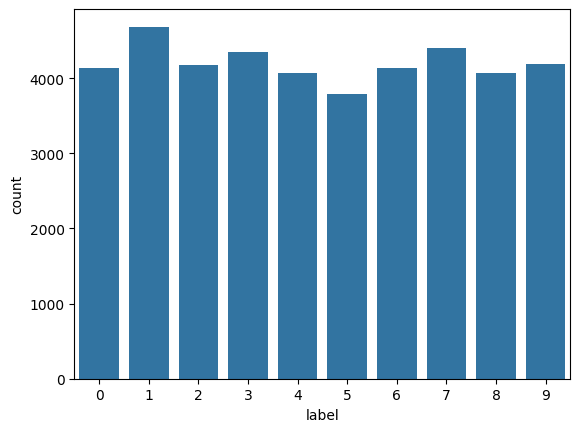

In [9]:
# use only label column for Y_train
Y_train = train["label"]

# Drop the label column for X_train
X_train = train.drop(labels = ["label"],axis = 1)

# Let's see what is the Y_train looks like
sns.countplot(x=Y_train)
Y_train.value_counts()

The sample number is identical and pretty balanced


## Missing Values


In [8]:
# Check missing values
print('Missing Values Train-set :',train.isnull().values.any())
print('Missing Values Test-set :',test.isnull().values.any())

Missing Values Train-set : False
Missing Values Test-set : False


which means there are no missing values in both train and test set

## Data Splitting

In [10]:
# Data Normalization
X_train = X_train / 255.0
X_test = test / 255.0

# Data Reshape
X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)

# Encoding
Y_train = tf.keras.utils.to_categorical(Y_train, num_classes = 10)

**1. Data Normalization**

Each pixel value in the training data (`X_train`) is divided by 255.0. This step normalizes the pixel values to be in the range [0, 1]. This normalization is often performed to make training faster and more stable.

**2. Data Reshape**

reshapes the training data (`X_train`) into a 4D array with dimensions (-1, 28, 28, 1). The '-1' indicates that the size of that dimension will be inferred based on the other dimensions. The '28, 28, 1' indicates that each image is 28x28 pixels with a single color channel (grayscale).

**3. Encoding**

This line encodes the target labels (`Y_train`) into categorical format using one-hot encoding. Each label is converted into a binary vector of length equal to the number of classes (in this case, 10), with a 1 in the position corresponding to the class and 0s elsewhere. This format is often used for multiclass classification tasks in neural networks.

In [11]:
# Data Splitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=.1, random_state=7)

This function is splitting the data into training and validation sets using `train_test_split`

`X_train` and `Y_train` are the features (input data) and labels (output data) respectively.
test_size=.1 indicates that 10% of the data will be used for validation, while the remaining 90% will be used for training.

`random_state=7` ensures that the random split is reproducible, meaning if you run this code multiple times with the same random_state, you will get the same split.

The function returns four variables: `X_train`, `X_val`, `Y_train`, and `Y_val`.

`X_train` and `Y_train` represent the features and labels of the training set respectively.
`X_val` and `Y_val` represent the features and labels of the validation set respectively.

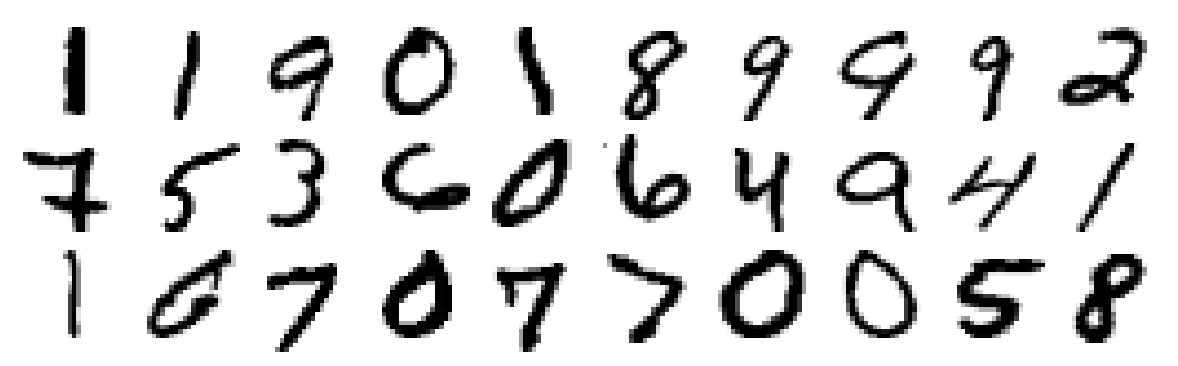

In [12]:
# Preview Images
plt.figure(figsize=(15,4.5))
for i in range(30):
    plt.subplot(3, 10, i+1)
    plt.imshow(X_train[i].reshape((28,28)),cmap=plt.cm.binary)
    plt.axis('off')
plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.show()

## Image Preprocessing

In [25]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
)

train_datagen.fit(X_train)

we use `ImageDataGenerator` class from the Keras library used for augmenting image data during training to increase the diversity of the training set and improve the generalization ability of the model. Here's what each part of the code does:

`rotation_range=20` : Randomly rotates images within the specified range (in degrees). In this case, images will be rotated by up to 20 degrees clockwise or counterclockwise.

`width_shift_range=0.05` : Randomly shifts images horizontally by a fraction of the total width. Here, images may be horizontally shifted by up to 5% of their total width.

`height_shift_range=0.05` : Randomly shifts images vertically by a fraction of the total height. Similar to width_shift_range, images may be vertically shifted by up to 5% of their total height.

`zoom_range=0.1` : Randomly zooms into images. A value of 0.1 means that images may be zoomed in by up to 10%.

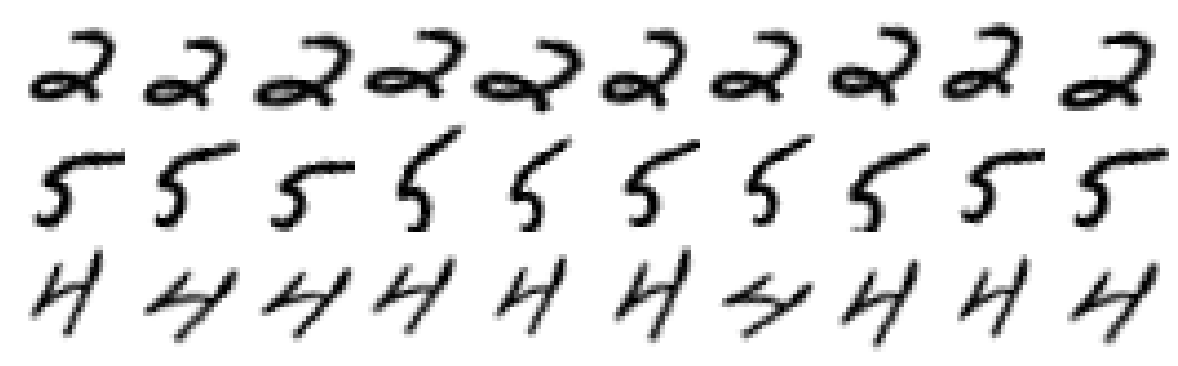

In [26]:
# Preview Augmented Images
X_train3 = X_train[9,].reshape((1,28,28,1))
Y_train3 = Y_train[9,].reshape((1,10))
plt.figure(figsize=(15,4.5))
for i in range(30):
    plt.subplot(3, 10, i+1)
    X_train2, Y_train2 = train_datagen.flow(X_train3,Y_train3).next()
    plt.imshow(X_train2[0].reshape((28,28)),cmap=plt.cm.binary)
    plt.axis('off')
    if i==9: X_train3 = X_train[11,].reshape((1,28,28,1))
    if i==19: X_train3 = X_train[18,].reshape((1,28,28,1))
plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.show()


This is the example of the images that have been augmented by ImageDataGenerator

# **Model Definition**

In [50]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28,28,1)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer='l2'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

`input_shape=(28,28,1)`: Specifies the shape of the input data. In this case, it's a grayscale image with dimensions 28x28 pixels.

`Conv2D` : These layers perform 2D convolution operations on the input data.

`activation='relu'` : ReLU (Rectified Linear Unit) activation function is applied to introduce non-linearity.

`padding='same'`: Padding is added to the input image to ensure that the output has the same spatial dimensions.

`BatchNormalization()`: Normalizes the activations of the previous layer at each batch.

`Dropout()`: Randomly sets a fraction of input units to 0 at each update during training to prevent overfitting.

`MaxPooling2D((2,2))`: Performs max pooling operation to reduce spatial dimensions by taking the maximum value within a 2x2 window.

`Flatten()` : Flattens the output of the previous layer into a one-dimensional array.

`Dense` : Fully connected layers where each neuron is connected to every neuron in the previous layer.

`kernel_regularizer`: Regularization applied to the kernel weights to prevent overfitting.

`softmax` activation function is used in the output layer for multiclass classification, providing probabilities for each class.

# **Model Compilation**

In [51]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001,decay_steps=10000,decay_rate=0.9,staircase=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_18 (Ba  (None, 28, 28, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_28 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_19 (Ba  (None, 28, 28, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 14, 14, 32)        0         
 ng2D)                                                           
                                                      

`Early Stopping Callback`, It sets up a mechanism to stop training early if the model's performance on the validation data stops improving. This helps prevent overfitting and saves time by avoiding unnecessary training epochs.

`Learning Rate Schedule`, It defines how the learning rate, which controls how much the model adjusts its parameters during training, changes over time. A decreasing learning rate helps the model converge more effectively towards a good solution.

`Optimizer`, It specifies the optimization algorithm used to update the model's parameters during training. The Adam optimizer is a popular choice for deep learning models due to its efficiency and effectiveness.

`Model Compilation`, It sets up the model for training by specifying the optimizer, loss function, and evaluation metrics.

`Model Summary`, It provides a summary of the model's architecture,

# **Model Training**

In [52]:
batch_size = 82
epochs = 50

history = model.fit(train_datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=early_stop)

Epoch 1/50
460/460 - 18s - loss: 2.2321 - accuracy: 0.8945 - val_loss: 0.7145 - val_accuracy: 0.9388 - 18s/epoch - 38ms/step
Epoch 2/50
460/460 - 13s - loss: 0.4875 - accuracy: 0.9555 - val_loss: 0.3460 - val_accuracy: 0.9817 - 13s/epoch - 29ms/step
Epoch 3/50
460/460 - 15s - loss: 0.3919 - accuracy: 0.9622 - val_loss: 0.3282 - val_accuracy: 0.9836 - 15s/epoch - 33ms/step
Epoch 4/50
460/460 - 13s - loss: 0.3738 - accuracy: 0.9630 - val_loss: 0.2845 - val_accuracy: 0.9881 - 13s/epoch - 29ms/step
Epoch 5/50
460/460 - 14s - loss: 0.3311 - accuracy: 0.9686 - val_loss: 0.2754 - val_accuracy: 0.9855 - 14s/epoch - 30ms/step
Epoch 6/50
460/460 - 14s - loss: 0.3309 - accuracy: 0.9671 - val_loss: 0.2636 - val_accuracy: 0.9890 - 14s/epoch - 30ms/step
Epoch 7/50
460/460 - 15s - loss: 0.3089 - accuracy: 0.9703 - val_loss: 0.2847 - val_accuracy: 0.9812 - 15s/epoch - 33ms/step
Epoch 8/50
460/460 - 14s - loss: 0.3140 - accuracy: 0.9700 - val_loss: 0.2578 - val_accuracy: 0.9900 - 14s/epoch - 30ms/step


# **Model Evaluation**

In [55]:
results = np.zeros((X_test.shape[0],10))
results = results + model.predict(X_test)
results = np.argmax(results,axis = 1)
results = pd.Series(results,name="Label")
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("mnist_digit_recognizer.csv",index=False)

875/875 [==============================] - 2s 2ms/step


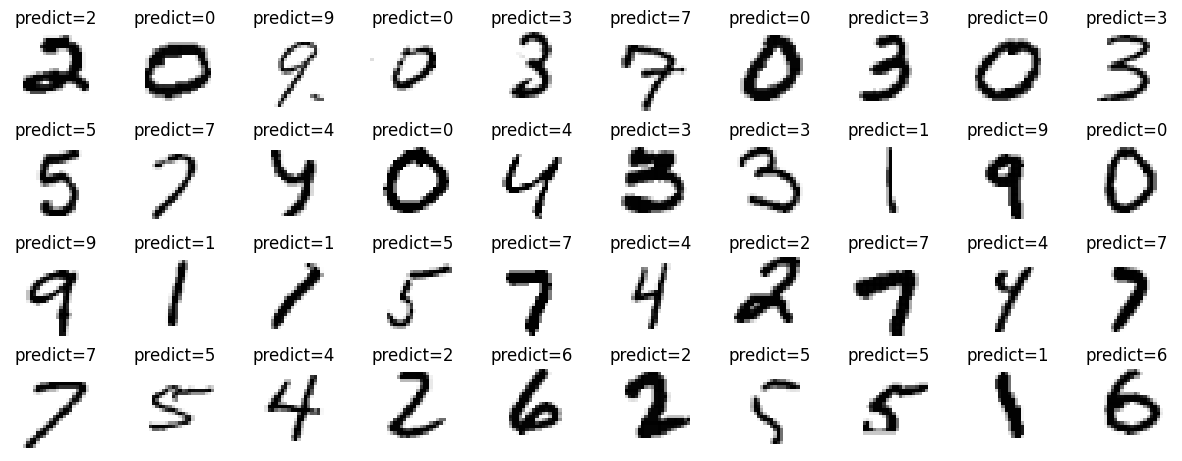

In [56]:
# Preview Predictions
plt.figure(figsize=(15,6))
for i in range(40):
    plt.subplot(4, 10, i+1)
    plt.imshow(X_test[i].reshape((28,28)),cmap=plt.cm.binary)
    plt.title("predict=%d" % results[i],y=0.9)
    plt.axis('off')
plt.subplots_adjust(wspace=0.3, hspace=-0.1)
plt.show()

# **Conclusion**

In this project, a Convolutional Neural Network (CNN) architecture was employed using TensorFlow to accomplish the task of recognizing handwritten digits from the MNIST dataset.

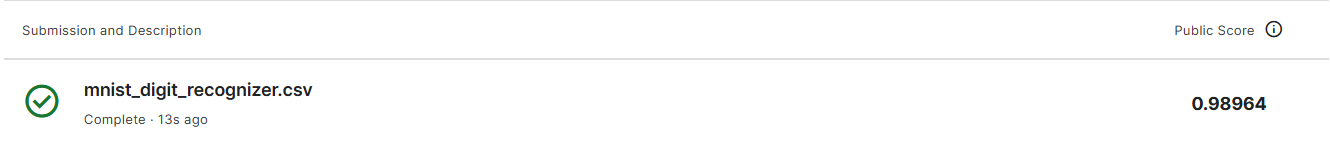